# Вам предстоит решать задачу классификации изображений методом логистической регрессии. 

В итоге вы должны получить  функцию $f(x) \to [0,1]^{10}$, которая на вход получает картинку с написанной от руки цифрой, а на выход дает 10 вероятностей от 0 до 1 принадлежности к каждому из классов (цифре). Картинка это вектор из (8*8) = 64 чисел. Мы будем рассматривать параметрическое семейство функций $F(c)$, таких,  что если $f_с \in F$, то она удовлетворяет нашим требованиям. Кроме того, для каждой функции  $f_c \in F$ мы можем посчитать, насколько она хорошо работает на некотором наборе картинок - это будет функционал качества этой функции $loss(f_c, images)$. Чем он меньше, тем лучше: в идеале $loss$ будет давать $0$ в том случае, если наша функция на всех картинках, на которых нарисована цифра $i$ выдала вектор, где все числа отличны от $1$ и только на $i-м$ месте стоит $1$. Иначе это будет некоторое положительное число, которое тем больше, чем хуже работает классификатор (потеря)

Итак, возьмем функцию $g(c) = loss(f_c, images)$ и будем ее минимизировать. Если мы найдем глобальный минимум, то научимся максимально качественно решать задачу классификации с помощью того семейства функций, которое мы выбрали. Глобальный минимум мы, конечно, не сможем аналитически найти, поэтому будем решать задачу минимизации методом градиентного спуска.

# Возьмем датасет нарисованных от руки картинок

In [150]:

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import math
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
from tqdm import tqdm

digits = load_digits()

In [11]:
digits.data.shape

(1797, 64)

# Пример содержимого датасета

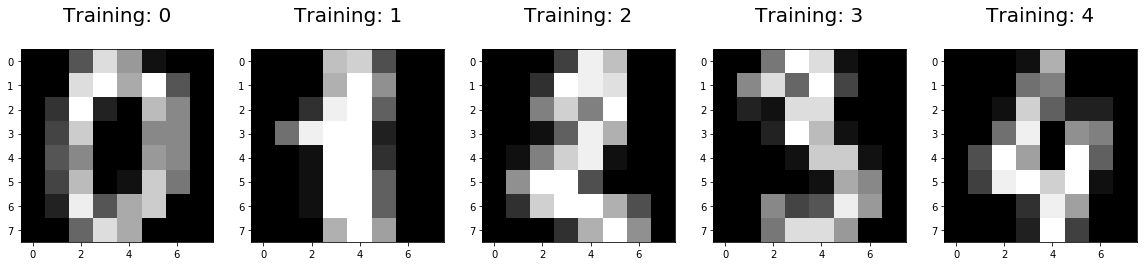

In [12]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

# Разделим датасет на 2 части - train и validate
1. На первой мы будем решать оптимизационную задачу - искать такую функцию, которая по картинке выдает правильную цифру. 
2. На второй будем независимо проверять, насколько качественно работает наша функция

Это необходимо для того, чтобы понимать, насколько наша функция реально умеет решать поставленную задачу: понимать, где какая цифра. У нас ограниченная выборка - всего 1797 картинок. Но в реальности нарисованных цифр может быть значительно больше! Если даже наша функция безошибочно работает на всех 1797 картинках, но ошибается вне - это плохо. Обычно график обучения должен выглядит примерно так, если зеленое - обучающая выборка, а красное - валидационная

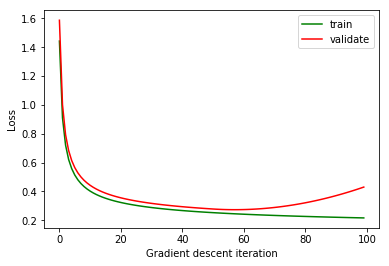

In [13]:
plt.plot(
    [1/math.log(i+2) for i in range(100)], 
    color='green', 
    label='train'
)

plt.plot(
    [1/math.log(i+2)*1.1+( (i/50.0-1)**2./5. if i>50 else 0.) for i in range(100)],
    color='red',
    label='validate')

plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

То есть с каждым шагом мы уменьшаем наш loss на обучающей выборке за счет градиентного спуска, но в какой-то момент функция может начать хорошо работать только на обучающей выборке. Этот эффект (в данном примере около 55 итерации по оси x) назвается переобучением.

# Вернемся к задаче
## Преобразуем числа от 0 до 9 в вектора из 10 элементов, где на i-m месте стоит 1, если цифра равна i и 0 иначе. 

## Также нормализуем картинки: все пиксели - это числа от 0 до 16. Сделаем их от -1 до 1, это улучшит качество нашей модели

In [14]:
def one_hot(y, n_classes):
    # делаем вектор из 10 координат с 0 везде кроме правильного ответа
    tmp = np.zeros(
        (len(y), n_classes), 
        dtype=np.uint8
    )
    tmp[range(len(tmp)), y] = 1
    return tmp

x_train, x_test, y_train, y_test = train_test_split(
    (digits.data-8)/16, 
    one_hot(digits.target,10),
    test_size=0.33, 
    random_state=0
)

# Задание: реализовать методом градиентного спуска логистическую регрессию. Начиная с этой ячейки и ниже разрешено использовать только стандартные функции  python и библиотеки numpy и  matplotlib

Для каждой картинки мы хотим найти вектор $(p_0,\ldots,p_{10})$, вероятностей, такой, что $p_i$ - вероятность того, что на картинка цифра $i$.

Реализуя логистическую регрессию, мы хотим приближать вероятности к их настоящему распределению. 

Выражение выдает ответ вида 
$$
A x + b
$$


где x - наш вектор картинки, а результат - числовой вектор размерности 10 с какими-то числами. Для того, чтобы эти числа стали вероятностями от 0 до 1, реализуем функцию 
$$
softmax(x) = \frac{e^x}{\sum(e^x)}
$$
и полученные значения будут как раз давать в сумме 1 и ими мы будем приближать вероятности. 

Оценивать качество нашей модели будем с помощью кросс-энтропии, см https://en.wikipedia.org/wiki/Cross_entropy 



Нормализуем компоненты, от этого софтмакс не изменится и мы будем брать экспоненты от каких-то разумных (по размеру) чисел

Согласно статье https://deepnotes.io/softmax-crossentropy так как мы используем экспоненту, то можем легко уйти за границы float64.

In [223]:
def softmax(W,b,x):
    #todo - а можно ли написать лучше? и чем ваше решение лучше?
    
    b = np.tile(b.reshape(-1, 1), (1, x.shape[1]))
    tmp = np.exp(W @ x + b -  np.max(W @ x + b)).T
    return (tmp.T/tmp.sum(axis=1)).T

#todo - реализовать кросс-энтропию от предсказанного вектора pred и данного вектора y
def loss (y, pred):
    return np.mean(-np.sum(y * np.log(pred) , axis=1))

# В данной точке x нужно научиться считать градиент. Выведите правила и посчитайте градиент в точке. Для того, чтобы выбирать градиент по всем точкам, можно его усреднить.

по статье https://deepnotes.io/softmax-crossentropy

Найдем производные от софтмакса:

для $i$-ой компоненты по $i$-тому элементу:
$$ \left(\frac{e^{x_i}}{\sum e^{x_i}}\right)^{'}_{x_i} = \frac{e^{x_i}(\sum e^{x_i} - e^{x_i})}{(\sum e^{x_i})^2} = p_i(1-p_i)$$

где $p_i = \frac{e^{x_i}}{\sum e^{x_i}}$


для $i$-ой компоненты по $i$-тому элементу:

$$ \left(\frac{e^{x_i}}{\sum e^{x_i}}\right)^{'}_{x_j} = \frac{-e^{x_i}e^{x_j}}{(\sum e^{x_i})^2} = -p_ip_j$$

где $p_i = \frac{e^{x_i}}{\sum e^{x_i}}$, $p_j = \frac{e^{x_j}}{\sum e^{x_i}}$

А в общем виде: $$\frac{\partial p_i}{\partial x_j} = (\delta_{ij} - p_i)p_j $$

где $\delta_{ij} = \begin{cases}1 && если \ \ i = j \\ 0 &&  иначе\end{cases}$

Теперь найдем производную по элементу $w_{i, j}$ от функции $loss(y, p) = \sum_\limits{i=0}^{9} -y_ilog(p_i)$ в точке $x_j$ (в нашей задаче 10 классов -- цифры от 0 до 9)

$$ loss^{'}_{w_{i, j}} = (-\sum y_ilog(p_i))^{'}_{w_{i,j}} softmax^{'} = (\frac{-y_ix_j}{p_i} - \frac{(1-y_i)x_j}{1-p_i})  p_i(1-p_i) = \frac{x_j(p_i-y_i)}{p_i(1-p_i)} = x_j(p_i-y_i)$$



для b_i:

$$ loss'_{b_i} = p_i-y_i $$

In [224]:
# todo затехать производную софтмакса

In [225]:
#todo - расчитать градиент 
def compute_gradients(out,y,x):
    w_grad = (out - y) * x.reshape(-1, 1)
    b_grad = out - y
    
#     print('!!', w_grad)
    return np.hstack((w_grad.T, b_grad.reshape(-1, 1)))

#усредняем по всем точкам
def gradients(W,b, x,y):
    sm = softmax(W,b,x.T)
    e = [ compute_gradients(a,c,b) for a,c,b in zip(sm,y,x) ]                         
    return np.mean(e,axis=0).T

# Методом градиентного спуска с постоянным шагом минимизируйте loss на обучающей выборке.

In [226]:
# Инициализируем шаг нашего спуска
eta = 1

# cделаем так, чтобы в итоге в Wx + b у нас была строчка (или столбец) длины 10 (количество классов)
W = np.zeros((10, 64))
b = np.zeros(10)

#будем записывать потери на каждом шаге спуска
losses_train=[]
losses_valid=[]

#собственно сам спуск
for k in tqdm(range(5000)):
    grads = gradients(W, b, x_train, y_train)
    
    W -= eta * (grads.T)[:, :-1]
    b -= eta * (grads.T)[:, -1]
    
    losses_train.append( loss(y_train, softmax(W, b, x_train.T) ) )
    losses_valid.append( loss(y_test, softmax(W, b, x_test.T)) )

100%|██████████| 5000/5000 [02:00<00:00, 41.54it/s]


Посмотрим какой ответ выдает на произвольной фотографии тестовой выборки:

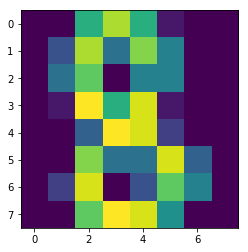

In [228]:
plt.imshow((x_test[8] * 16 + 8).reshape(8, 8))

In [230]:
sofrtmax_test = softmax(W, b.T, x_test[8].reshape(-1, 1))
np.argmax(sofrtmax_test)

8

# Нарисуйте графики ошибки (loss) от номера шага градиентного спуска. Как падала ошибка на обучающей и тестовой выборках? На каком шаге ошибка на обучающей выборке оказалась минимальной?

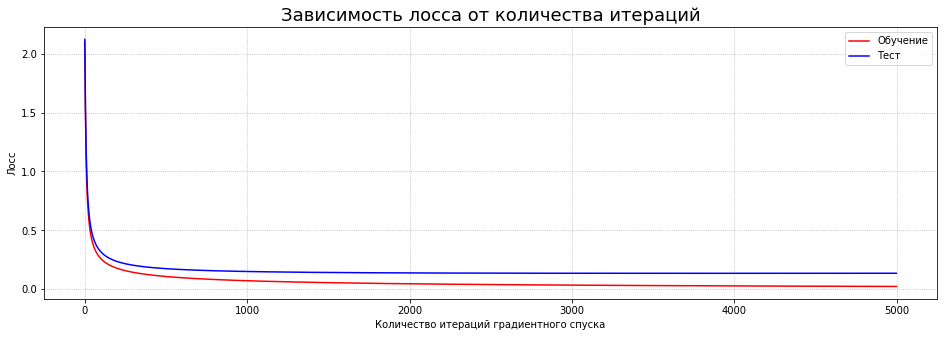

In [116]:
plt.figure(figsize=(16, 5))
plt.plot(np.array(losses_train), 'r', label='Обучение')
plt.plot(np.array(losses_valid), 'b', label='Тест')
plt.grid(ls=":")
plt.title('Зависимость лосса от количества итераций', fontsize=18)
plt.xlabel('Количество итераций градиентного спуска')
plt.ylabel('Лосс')
plt.grid(ls=":")
plt.legend()
plt.show()

Как видно из графика выше ошибка вначале, в силу того, что параметры инициализации вообще не являлись минимумом лосса. Потом алгоритм постепенно начал сходиться и лосс уменьшается, но уменьшается незначительно. Давайте найдем момент переобучения, т.е. ту точку, в которой лосс на тесте начинает увеличиваться:

In [117]:
n_min_valid_loss = np.argmin(losses_valid)

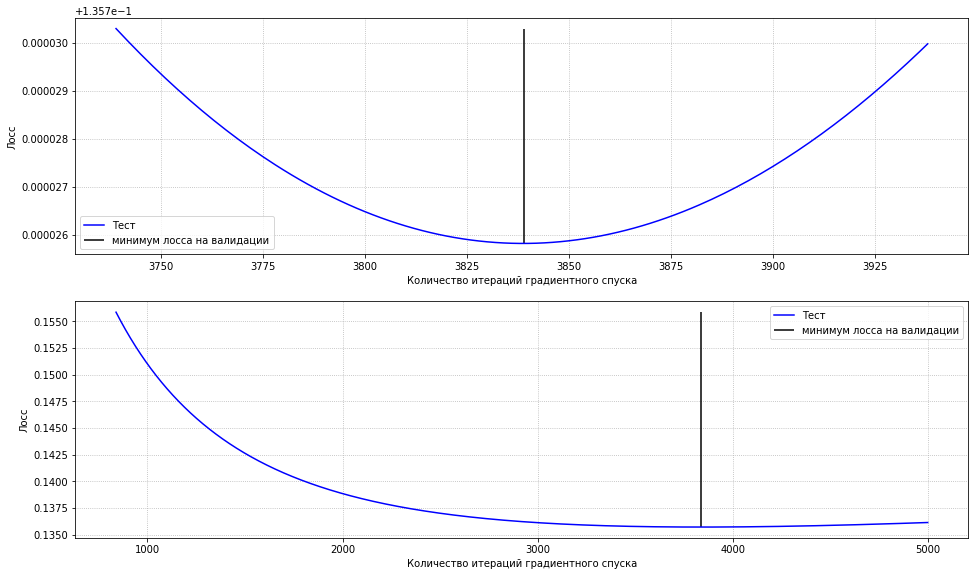

In [131]:
plt.figure(figsize=(16, 20))
for i, step in enumerate([100, 3000]):
    plt.subplot(4, 1, i + 1)
    data = np.array(losses_valid)[n_min_valid_loss - step:n_min_valid_loss + step]
    max_ = np.max(data)
    min_ = np.min(data)
    plt.plot(np.arange(len(data)) + n_min_valid_loss - step, data, 'b', label='Тест')
    plt.vlines(n_min_valid_loss, min_, max_, label='минимум лосса на валидации')
    plt.xlabel('Количество итераций градиентного спуска')
    plt.ylabel('Лосс')
    plt.grid(ls=":")
    plt.legend()
plt.show()

# Реализуйте выбор шага градиентного спуска методом Армихо. Ускорило ли использование метода Армихо с начальными параметрами
$$ s=100, \beta=\alpha=0.5$$
# достижение минимума на обучающей выборке по сравнению с фиксированным шагом 100? А на валидационной?

### Фиксированный шаг 100:

In [162]:
# Инициализируем шаг нашего спуска
eta = 100

# cделаем так, чтобы в итоге в Wx + b у нас была строчка (или столбец) длины 10 (количество классов)
W = np.zeros((10, 64))
b = np.zeros(10)

#будем записывать потери на каждом шаге спуска
losses_train_eta_100=[]
losses_valid_eta_100=[]

#собственно сам спуск
for k in tqdm(range(5000)):
    grads = gradients(W, b, x_train, y_train)
    
    W -= eta * (grads.T)[:, :-1]
    b -= eta * (grads.T)[:, -1]
    
    losses_train_eta_100.append( loss(y_train, softmax(W, b, x_train.T) ) )
    losses_valid_eta_100.append( loss(y_test, softmax(W, b, x_test.T)) )

100%|██████████| 5000/5000 [01:58<00:00, 42.36it/s]


In [160]:
def armijo(W, b, x, y, dW, db, alpha=0.5, beta=0.5, s_0=100):
    s = s_0
    sm = softmax(W, b, x.T)
    d_sm = softmax(W - s * dW, b - s * db, x.T)
    
    grads_w = dW.reshape(1, -1)
    grads_b = db.reshape(1, -1)
    grads = np.hstack((grads_w, grads_b))
    
    while (loss(y, d_sm) > loss(y, sm) - alpha * s * np.sum(grads ** 2)):
        s = beta * s
        d_sm = softmax(W - s * dW, b - s * db, x.T)
        
    return s

### Шаг с Армихо s=100, β=α=0.5:

In [199]:
# Инициализируем шаг нашего спуска
eta = 100

# cделаем так, чтобы в итоге в Wx + b у нас была строчка (или столбец) длины 10 (количество классов)
W = np.zeros((10, 64))
b = np.zeros(10)

#будем записывать потери на каждом шаге спуска
losses_train_armijo=[]
losses_valid_armijo=[]

#собственно сам спуск
for k in tqdm(range(30000)):
    grads = gradients(W, b, x_train, y_train)
    dW = (grads.T)[:, :-1]
    db = (grads.T)[:, -1]
    eta = armijo(W, b, x_train, y_train, dW, db)
    
    W -= eta * (grads.T)[:, :-1]
    b -= eta * (grads.T)[:, -1]
    
    losses_train_armijo.append( loss(y_train, softmax(W, b, x_train.T) ) )
    losses_valid_armijo.append( loss(y_test, softmax(W, b, x_test.T)) )

100%|██████████| 30000/30000 [12:28<00:00, 40.07it/s]


### Ускорило ли использование метода Армихо с начальными параметрами s=100,β=α=0.5 достижение минимума на обучающей выборке по сравнению с фиксированным шагом 100? А на валидационной?

#### проверим это:

In [200]:
argmin_train_100 = np.argmin(losses_train_eta_100)
argmin_valid_100 = np.argmin(losses_valid_eta_100)
min_train_100 = np.min(losses_train_eta_100)
min_valid_100 = np.min(losses_valid_eta_100)

In [201]:
print('минимум при фиксированном шаге 100 на обучении достигается на шаге = {}\nНа валидации на шаге = {}'.format(argmin_train_100, argmin_valid_100))
print('значение минимума на обучении = {}\nНа валидации = {}'.format(min_train_100, min_valid_100))

минимум при фиксированном шаге 100 на обучении достигается на шаге = 4999
На валидации на шаге = 4999
значение минимума на обучении = 6.493750682681312e-05
На валидации = 0.7735892418951557


In [205]:
argmin_train_armijo = np.argmin(losses_train_armijo)
argmin_valid_armijo = np.argmin(losses_valid_armijo)
min_train_armijo = np.min(losses_train_armijo)
min_valid_armijo = np.min(losses_valid_armijo)

In [206]:
print('минимум методом Армихо на обучении достигается на шаге = {}\nНа валидации на шаге = {}'.format(argmin_train_armijo, argmin_valid_armijo))
print('значение минимума на обучении = {}\nНа валидации = {}'.format(min_train_armijo, min_valid_armijo))

минимум методом Армихо на обучении достигается на шаге = 29999
На валидации на шаге = 159
значение минимума на обучении = 6.417011544362674e-05
На валидации = 0.13525619795078273


Как мы видим, градиентный спуск с фиксированным большим шагом так и не смог сойтись на валидации, достигнув минимальное значение на валидации всего лишь $0.77$

Армихо же уже на 159 шаге смог достигнуть минимум, который почти в 6 раз меньше, чем у обычного спуска!

Вопрос про достижение минимума на обучении получился каким-то странным, но могу сказать, что мы остановимся только блягодаря какому-нибудь кретирию останова (когда разность между $x_{k + 1}$ и $x_{k}$ меньше какого-то $\varepsilon$ или разность лоссов на соседних шагах меньше $\varepsilon$), которого у нас нет. Поэтому мы не сойдемся, а будем все больше и больше подстраиваться под обучающую выборку, уменьшая лосс на ней

# Какую долю картинок из валидационной выборки удается предсказать правильно? Приведите примеры из валидационной выборки, где модель ошибается и где работает правильно

Обучим модель, хорошо показывающую себя на валидации (Армихо, 160 итераций)

In [231]:
eta = 100
W = np.zeros((10, 64))
b = np.zeros(10)

for k in tqdm(range(160)):
    grads = gradients(W, b, x_train, y_train)
    dW = (grads.T)[:, :-1]
    db = (grads.T)[:, -1]
    eta = armijo(W, b, x_train, y_train, dW, db)
    
    W -= eta * (grads.T)[:, :-1]
    b -= eta * (grads.T)[:, -1]

100%|██████████| 160/160 [00:04<00:00, 37.62it/s]


### Какую долю картинок из валидационной выборки удается предсказать правильно?

In [232]:
def accuracy_score(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

In [233]:
y_true = np.argmax(y_test, axis=1)

In [234]:
y_pred = np.argmax(softmax(W, b, x_test.T), axis=1)

In [235]:
accuracy_score(y_pred, y_true)

0.95622895622895621

Точность в  $95-96\%$ --- достаточно хорошо)

### Приведите примеры из валидационной выборки, где модель ошибается и где работает правильно

In [220]:
valid_false_samples = x_test[np.where(y_true != y_pred)[0], :]
valid_false_pred_labels = y_pred[np.where(y_true != y_pred)[0]]
valid_false_true_labels = y_true[np.where(y_true != y_pred)[0]]
valid_true_samples = x_test[np.where(y_true == y_pred)[0], :]
valid_true_pred_labels = y_pred[np.where(y_true == y_pred)[0]]
valid_true_true_labels = y_true[np.where(y_true == y_pred)[0]]

### примеры, где модель ошибается

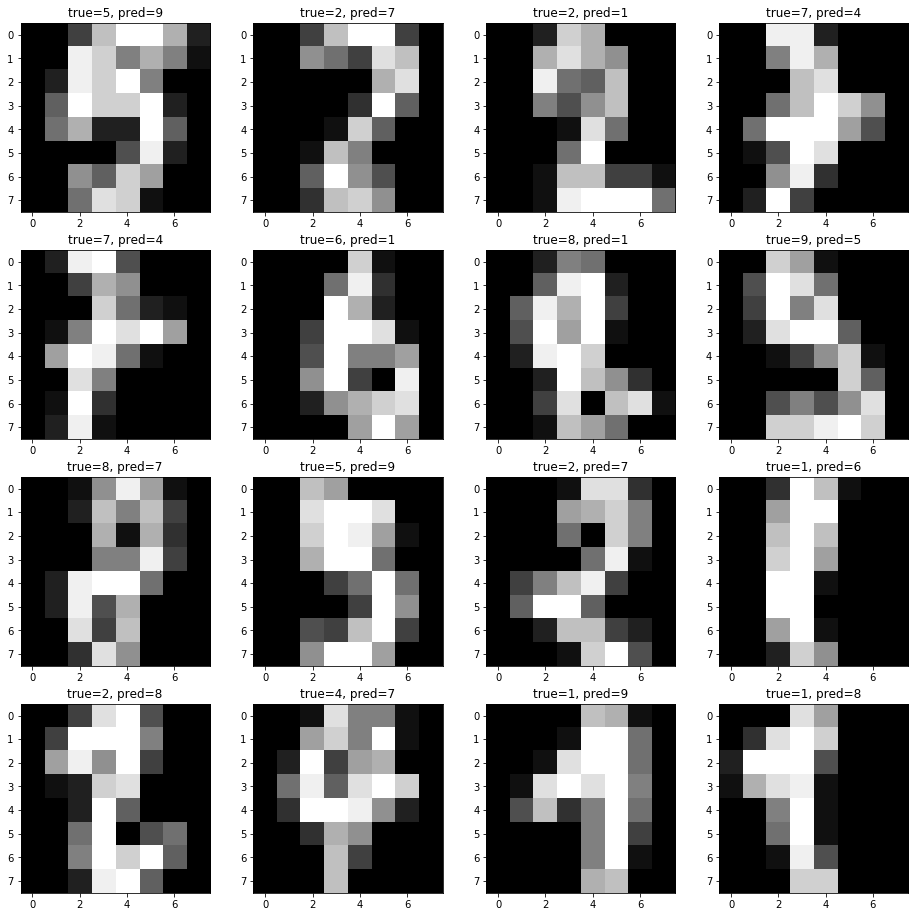

In [218]:
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow((valid_false_samples[i] * 16 + 8).reshape(8, 8), cmap='gray')
    plt.title('true={}, pred={}'.format(valid_false_true_labels[i], valid_false_pred_labels[i]))

### Примеры, где модель работает корректно

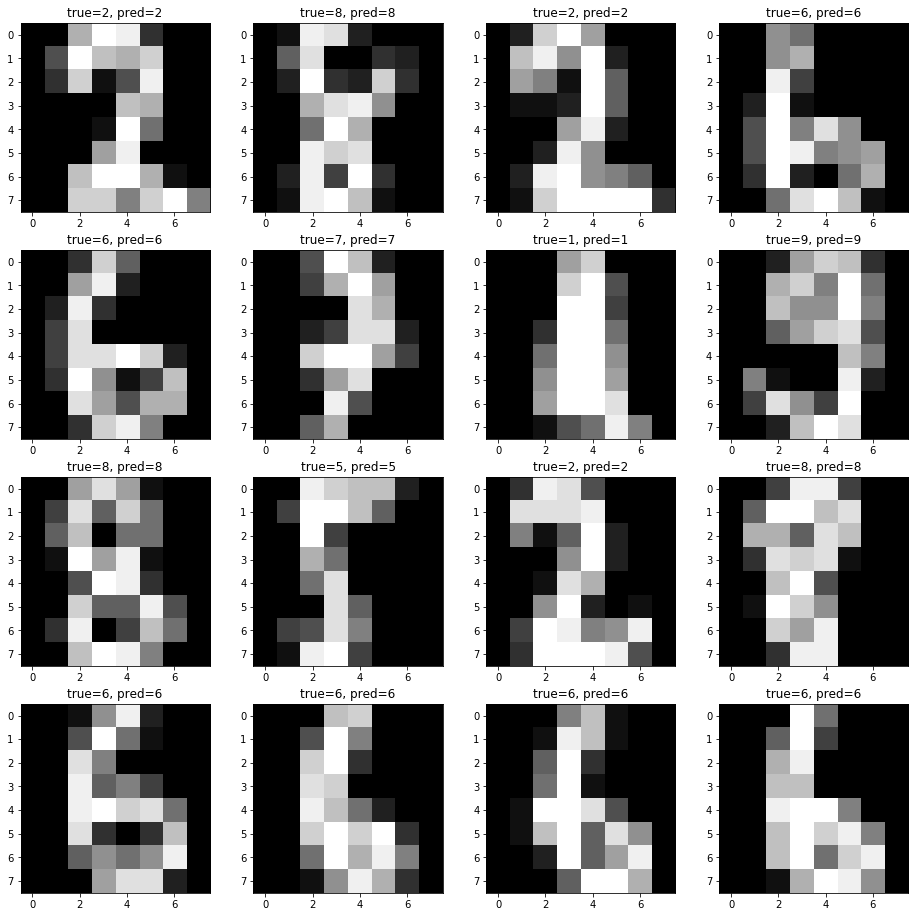

In [221]:
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow((valid_true_samples[i] * 16 + 8).reshape(8, 8), cmap='gray')
    plt.title('true={}, pred={}'.format(valid_true_true_labels[i], valid_true_pred_labels[i]))